In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [40]:
df = pd.read_csv("ICBHI 2017/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")
df.head()

,101,URTI
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD


In [41]:
df['URTI'].unique()

array(['Healthy', 'Asthma', 'COPD', 'URTI', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [42]:
sr_no = {'101':'URTI'}
for i, j in zip(df['101'].unique(), df['URTI']):
    sr_no[str(i)] = j

In [43]:
sr_no.keys()

dict_keys(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226'])

In [44]:
import os
sound_files = os.listdir('Mel Spectrogram/Original')

In [45]:
req_file_names = []

for i in sound_files:
      req_file_names.append([i])

In [46]:
labels = []
for i in range(len(req_file_names)):
    req_file_names[i].append(sr_no[req_file_names[i][0][:3]])
    labels.append(sr_no[req_file_names[i][0][:3]])

In [47]:
labels *= 3

In [48]:
x = []

for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Time Stretch/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Pitch Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)
    
for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Audio Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

# x = np.array(x)
# print(x.shape)

In [49]:
x_new = []
y = []

for i in range(len(labels)):
    if labels[i]=='Asthma' or labels[i]=='Bronchiolitis':
        continue
    x_new.append(x[i])
    y.append(labels[i])

In [50]:
x = np.array(x_new)
print(x.shape)

(2718, 350, 350, 3)


In [51]:
req_file_names *= 3

In [52]:
y = np.array(y)
y.shape

(2718,)

In [53]:
one_hot_y = np.array(pd.get_dummies(y))

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, one_hot_y, test_size=0.2, random_state=39, stratify=y)
print(x_train.shape, y_train.shape, x_test.shape)

(2174, 350, 350, 3) (2174, 6) (544, 350, 350, 3)


In [55]:
xception_wo_top = keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(350,350,3))

In [56]:
xception_xtrain = xception_wo_top.predict(x_train)
xception_xtest = xception_wo_top.predict(x_test)

In [57]:
del x
del x_new
del x_train
del x_test
del xception_wo_top

In [58]:
input_xception = keras.layers.Input(shape=xception_xtrain.shape[1:])

# xception_layer = xception_wo_top(input_xception)

# random = np.random.random(xception_layer.shape[1:])

attention = keras.layers.Attention()([input_xception, input_xception])
flatten = keras.layers.Flatten()(attention)

dense1 = keras.layers.Dense(128, activation='relu')(flatten)
do1 = keras.layers.Dropout(0.3)(dense1)
bn1 = keras.layers.BatchNormalization()(do1)
dense2 = keras.layers.Dense(64, activation='relu')(bn1)
output = keras.layers.Dense(6, activation='softmax')(dense2)

xception_model = keras.Model(inputs=input_xception, outputs=output)
xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 11, 11, 204  0           []                               
                                8)]                                                               
                                                                                                  
 attention_1 (Attention)        (None, 11, 11, 2048  0           ['input_4[0][0]',                
                                )                                 'input_4[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 247808)       0           ['attention_1[0][0]']            
                                                                                            

In [59]:
checkpoint_xception = keras.callbacks.ModelCheckpoint('Results/Xception_Models/Xception_Model-{epoch:02d}.h5', save_best_only=True)

xception_model.compile(optimizer=keras.optimizers.Adam(3e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
history_xception = xception_model.fit(xception_xtrain, y_train, batch_size=32, epochs=250, validation_data=(xception_xtest, y_test), callbacks=[checkpoint_xception])

Epoch 1/250
68/68 [==============================] - 52s 637ms/step - loss: 1.3911 - accuracy: 0.4756 - val_loss: 0.7295 - val_accuracy: 0.8088
Epoch 2/250
68/68 [==============================] - 43s 646ms/step - loss: 0.9635 - accuracy: 0.7171 - val_loss: 0.6475 - val_accuracy: 0.8401
Epoch 3/250
68/68 [==============================] - 22s 329ms/step - loss: 0.8190 - accuracy: 0.7879 - val_loss: 0.6242 - val_accuracy: 0.8511
Epoch 4/250
68/68 [==============================] - 21s 313ms/step - loss: 0.7166 - accuracy: 0.8280 - val_loss: 0.5678 - val_accuracy: 0.8621
Epoch 5/250
68/68 [==============================] - 41s 616ms/step - loss: 0.6589 - accuracy: 0.8546 - val_loss: 0.4975 - val_accuracy: 0.8750
Epoch 6/250
68/68 [==============================] - 35s 521ms/step - loss: 0.6165 - accuracy: 0.8625 - val_loss: 0.4877 - val_accuracy: 0.8695
Epoch 7/250
68/68 [==============================] - 14s 208ms/step - loss: 0.5825 - accuracy: 0.8776 - val_loss: 0.4897 - val_accuracy:

68/68 [==============================] - 41s 614ms/step - loss: 0.0704 - accuracy: 0.9986 - val_loss: 0.1612 - val_accuracy: 0.9540
Epoch 114/250
68/68 [==============================] - 14s 211ms/step - loss: 0.0700 - accuracy: 0.9977 - val_loss: 0.1655 - val_accuracy: 0.9522
Epoch 115/250
68/68 [==============================] - 38s 561ms/step - loss: 0.0688 - accuracy: 1.0000 - val_loss: 0.1608 - val_accuracy: 0.9540
Epoch 116/250
68/68 [==============================] - 38s 559ms/step - loss: 0.0681 - accuracy: 0.9977 - val_loss: 0.1606 - val_accuracy: 0.9577
Epoch 117/250
68/68 [==============================] - 17s 250ms/step - loss: 0.0639 - accuracy: 1.0000 - val_loss: 0.1635 - val_accuracy: 0.9540
Epoch 118/250
68/68 [==============================] - 214s 3s/step - loss: 0.0661 - accuracy: 0.9995 - val_loss: 0.1562 - val_accuracy: 0.9614
Epoch 119/250
68/68 [==============================] - 15s 216ms/step - loss: 0.0625 - accuracy: 0.9995 - val_loss: 0.1669 - val_accuracy: 0

68/68 [==============================] - 15s 214ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.9632
Epoch 226/250
68/68 [==============================] - 14s 213ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 0.9632
Epoch 227/250
68/68 [==============================] - 14s 213ms/step - loss: 0.0168 - accuracy: 0.9995 - val_loss: 0.1242 - val_accuracy: 0.9614
Epoch 228/250
68/68 [==============================] - 15s 216ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.1322 - val_accuracy: 0.9596
Epoch 229/250
68/68 [==============================] - 15s 215ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 0.9596
Epoch 230/250
68/68 [==============================] - 14s 212ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9577
Epoch 231/250
68/68 [==============================] - 14s 213ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy:

In [61]:
df = pd.DataFrame(history_xception.history)
df.to_csv('Results/Xception_history.csv')

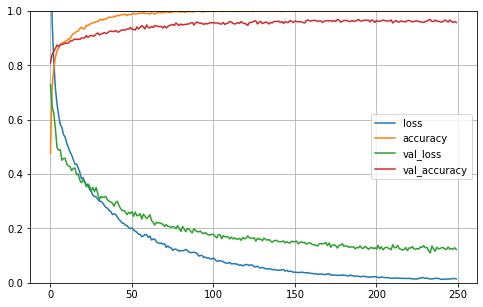

In [62]:
pd.DataFrame(history_xception.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig("Results/Xception_Attention_Graph.png")
plt.show()

In [69]:
xception_model = keras.models.load_model("Results/Xception_Models/Xception_Model-88.h5")

In [70]:
y_pred = xception_model.predict(xception_xtest)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_test:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

[[  9   1   0   0   0   0]
 [  0 472   1   0   3   0]
 [  1   6  12   0   1   1]
 [  0   0   0   1   0   0]
 [  0   5   0   0  17   0]
 [  0   1   3   0   0  10]]


(0.9577205882352942,
 0.9550147677393357,
 0.9577205882352942,
 0.9555084099952114)

In [71]:
y_pred = xception_model.predict(xception_xtrain)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_train:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

[[  38    0    0    0    0    0]
 [   0 1903    0    0    0    0]
 [   0    0   84    0    0    0]
 [   0    0    0    5    0    0]
 [   0    0    0    0   89    0]
 [   0    0    0    0    0   55]]


(1.0, 1.0, 1.0, 1.0)